# Jimi Togni - RA: 226359
# Rodrigo de Freitas Pereira - RA: 

-----------

## Parte 1 – Classificação binária


In [57]:
#importando pacotes essenciais

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.spatial.distance import correlation as dcorrelation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from datetime import date

sns.set(style="white")
%matplotlib inline

In [58]:
def gen_confusion_matrix(y, yh):
    cls = np.unique(y)
    confusion_m = np.zeros((cls.size, cls.size))
    for i, yhto in enumerate(y):
        for cl in cls:
            if yhto == yh[i] and yhto == cl:
                confusion_m[cl, cl] += 1
                break
            elif yhto != yh[i]:
                confusion_m[yhto, yh[i]] += 1
                break
    return confusion_m

def gen_classification_report(confusion_m):
    cls, _ = confusion_m.shape
    cls = range(cls)
    report = {(i+1): {"precision": 0, "recall": 0, "f1-score": 0, "support": 0} for i in cls}
    for r in cls:
        for c in cls:
            if r == c:
                tp = confusion_m[r, c]
                tn = np.diagonal(confusion_m) - tp
                fp = np.sum(confusion_m[:, c])
                fn = np.sum(confusion_m[r, :])
                P, R = np.round(tp / fp, 2), np.round(tp / fn, 2)
                report[r+1]["support"] = tp + (fn - tp)
                report[r+1]["precision"] = P
                report[r+1]["recall"] = R
                report[r+1]["f1-score"] = np.round((2 * (P * R)) / (P + R), 2)
    return report

def one_hot_encode(y):
    return pd.get_dummies(y).values


class LogisticRegressionImpl():
        
    def __init__(self, fit_intercept=True, decay=1e-4, batch_size=32, weights=None):
        self.w = weights
        self.fit_intercept = fit_intercept
        self._decay = decay
        self._batch_size = batch_size
    
    def _one_hot_encode(self, y):
        return pd.get_dummies(y).values
        
    def __softmax(self, z):
        e_x = np.exp(z.T - np.max(z, axis=1)) 
        return (e_x / e_x.sum(axis=0)).T
    
    def __sigmoid(self, z):
        return 1./(1 + np.exp(-z))
    
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def _shuffle(self, X, y):
        permutation = np.random.permutation(X.shape[0])
        if self.__cls > 2:
            return X[permutation, :], y[permutation, :]
        return X[permutation, :], y[permutation]
    
    def train(self, x, y, lr=1e-4, epochs=10000):
        # Check to see the number of classes 
        uniq = np.unique(y)
        self.__activation = self.__sigmoid
        self.__cls = uniq.shape[0]
        if self.__cls > 2:
            y = self._one_hot_encode(y)
            self.__activation = self.__softmax
        # Train and validation sets
        x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.7)
        # Should we add a intercept
        x_train, x_val = self._add_intercept(x_train), self._add_intercept(x_val)
        # Number of samples
        self.N = y.size
        # Initialize weights
        if self.w is None:
            self.w = np.random.rand(x_train.shape[1], ) * np.sqrt(2 / (self.N + 2))
            if self.__cls > 2:
                self.w = np.random.rand(x_train.shape[1], self.__cls) * np.sqrt(2 / (self.N + self.__cls))

        # Train loop Gradient Descent
        J, ACC = [], []
        mb = np.ceil(x_train.shape[0] / self._batch_size).astype(np.int32)
        for i in range(epochs):
            # Shuffle dataset in each epoch
            x_train, y_train = self._shuffle(x_train.copy(), y_train.copy())
            r = 0
            for _ in range(mb):
                # Mini batch crop
                ini, end = r * self._batch_size, (r + 1) * self._batch_size
                batch_X, batch_y = x_train[ini:end, :], y_train[ini:end]
                if self.__cls > 2:
                    batch_X, batch_y = x_train[ini:end, :], y_train[ini:end, :]
                r += 1
                # Forward
                yh = self.__activation(np.dot(batch_X, self.w))
                # Gradient
                dw = (1 / self.N) * np.dot(batch_X.T, (yh - batch_y))
                # Weight adjust with regularization
                self.w = (self.w - (lr * dw)) - (((lr * self._decay) / self.N) * self.w)
            # Validation Loss
            h = self.__activation(np.dot(x_val, self.w))
            # Accuracy
            ACC.append(np.round(self.__acc(y_val, h), 5))
            # Loss
            J.append(np.round(self.__loss(y_val, h), 5))
        return J, ACC

    def predict_proba(self, x):
        x = self._add_intercept(x)
        return self.__activation(np.dot(x, self.w))
    
    def predict(self, x, threshold=0.5):
        if self.__cls > 2:
            return np.argmax(self.predict_proba(x), axis=1)
        return (self.predict_proba(x) >= threshold).astype(np.int)
    
    def __acc(self, y, yh):
        Y, YH = y, (yh >= .5).astype(np.int)
        if self.__cls > 2:
            Y, YH = np.argmax(y, axis=1), np.argmax(yh, axis=1)
        return (
                np.round(
                    np.mean([y == yh for y, yh in zip(Y, YH)]), 2
                )
                * 100
            )
    
    def __loss(self, y, yh):
        L2 = (self._decay / (2 * self.N)) * np.sum([np.sum(np.square(w)) for w in self.w])
        if self.__cls > 2:
            n_samples = y.shape[0]
            logp = -np.log(yh[np.arange(n_samples), y.argmax(axis=1)])
            loss = np.sum(logp) / n_samples
            return loss + L2
        bce = -np.sum(np.multiply(y, np.log(yh)) + np.multiply((1-y), np.log(1 - yh)))
        return ((1 / self.N) * bce) + L2

In [4]:
#Regressao Logistica

In [53]:
#Regressao Logistica
#nao usar
"""
class LogisticRegression():
    
    def __init__(self, fit_intercept=True, reg=1e-20, weights=None):
        self.w = weights #pesos
        self.fit_intercept = fit_intercept
        self._reg = reg #regularização
        
    def __sigmoid(self, z):
        return 1.(1 + np.exp(-z)) #função sigmoid
    
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def train(self, x, y, lr=1e-5, epochs=10000):
        x =self._add_intercept(x)
        self.N = y.size
        
        if self.w is None:
            self.w = np.random.rand(x.shape[1], )* np.sqrt(2/(self.N + 2))
        
        J = []
        
        for i in range (epochs):
            #forward
            yh = self.__sigmoid(np.dot(x, self.w))
            
            #gradiente
            dw = (1 / self.N) * np.dot(x.T, (yh -y))
            
            #ajuste de pesos
            self.w = (self.w - (lr * dw)) - (((lr * self._reg / self.N) * self.w))
            
            #perdas
            h = self.__sigmoid(np.dot(x_val, self.w))
            loss = self.__loss(y_val, h)
            J.append(np.round(loss, 5))
        
        return self, J
    
    def predict_prob(self, x):
        x = self._add_intercept(x)
        return self.__sigmoid(np.dot(x, self.we))
    
            
   """

'\nclass LogisticRegression():\n    \n    def __init__(self, fit_intercept=True, reg=1e-20, weights=None):\n        self.w = weights #pesos\n        self.fit_intercept = fit_intercept\n        self._reg = reg #regularização\n        \n    def __sigmoid(self, z):\n        return 1.(1 + np.exp(-z)) #função sigmoid\n    \n    def _add_intercept(self, X):\n        intercept = np.ones((X.shape[0], 1))\n        return np.concatenate((intercept, X), axis=1)\n    \n    def train(self, x, y, lr=1e-5, epochs=10000):\n        x =self._add_intercept(x)\n        self.N = y.size\n        \n        if self.w is None:\n            self.w = np.random.rand(x.shape[1], )* np.sqrt(2/(self.N + 2))\n        \n        J = []\n        \n        for i in range (epochs):\n            #forward\n            yh = self.__sigmoid(np.dot(x, self.w))\n            \n            #gradiente\n            dw = (1 / self.N) * np.dot(x.T, (yh -y))\n            \n            #ajuste de pesos\n            self.w = (self.w - (l

Problema: identificação do gênero do locutor a partir de trechos de voz
Base de dados: dados_voz_genero.csv
https://www.mldata.io/dataset-details/gender_voice/

Você dispõe de um conjunto de dados contendo 3168 amostras rotuladas. Cada
amostra é descrita por 19 atributos acústicos extraídos de trechos gravados de voz,
considerando a faixa de frequências de 0 a 280 Hz. A última coluna corresponde ao
rótulo associado a cada padrão, sendo igual a ‘1’ para o gênero masculino, e ‘0’ para o
gênero feminino.

a) Faça uma análise das características dos atributos de entrada considerando os
respectivos histogramas e as medidas de correlação entre eles.

b) Construa, então, o modelo de regressão logística para realizar a classificação
dos padrões. Para isso, reserve uma parte dos dados (e.g., 20%) para teste,
usando todas as demais amostras para o treinamento do modelo. Pensem na
pertinência e na possibilidade de realizar algum pré-processamento nos dados
(e.g., normalização).
Apresente e discuta os seguintes resultados com relação ao conjunto de teste:

 A curva ROC;

 A curva de evolução da -medida em função do valor do threshold de
decisão.

c) Indique qual seria o valor mais adequado para o threshold de decisão e por
quê. Empregando, então, esse threshold, obtenha a matriz de confusão e a
acurácia do classificador para o conjunto de teste. Comente os resultados
obtidos.


In [59]:
#Visualizando os dados

df = pd.read_csv('dados_voz_genero.csv')
print(f"Shape of data{df.shape}")
print(f"First 10 rows{df.head(5)}")


#convertendo para numpy
#df = np.array(data)
#print(f"Shape of np_data{df.shape}")

#np_data[:10, [1,3]]
#primeiras 10 linhas e a primeira e ultima colunas 
#data_np[:10, [0,-1]]
#data.head(10)

#colunas
#data_np.dtypes

Shape of data(3168, 21)
First 10 rows   Unnamed: 0        sd    median       Q25       Q75       IQR       skew  \
0           0  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1           1  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2           2  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3           3  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4           4  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   m

### heatmap ta bugado

AttributeError: 'list' object has no attribute 'unique'

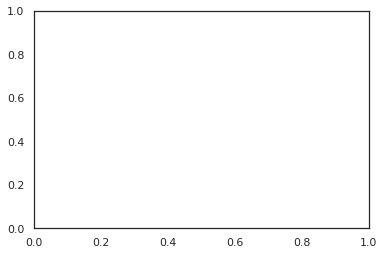

In [60]:
#matrix of correlation
#ta bugado

def heatmap (x, y, size):
    fig, ax = plt.subplots()
    
    #mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    
    ax.scatter(
        x = x.map(x_to_num), #map for x
        y = y.map(y_to_num), #map for x
        s = size * size_scale,
        marker = 's'
    )
    
    # show column axes labels
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
data = df
columns = ['skew', 'kurt', 'sp.ent', 'median', 'dfrange', 'modindx', 'maxdom']
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

heatmap(x=corr['x'], y=['y'], size=corr['value'].abs())

#ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

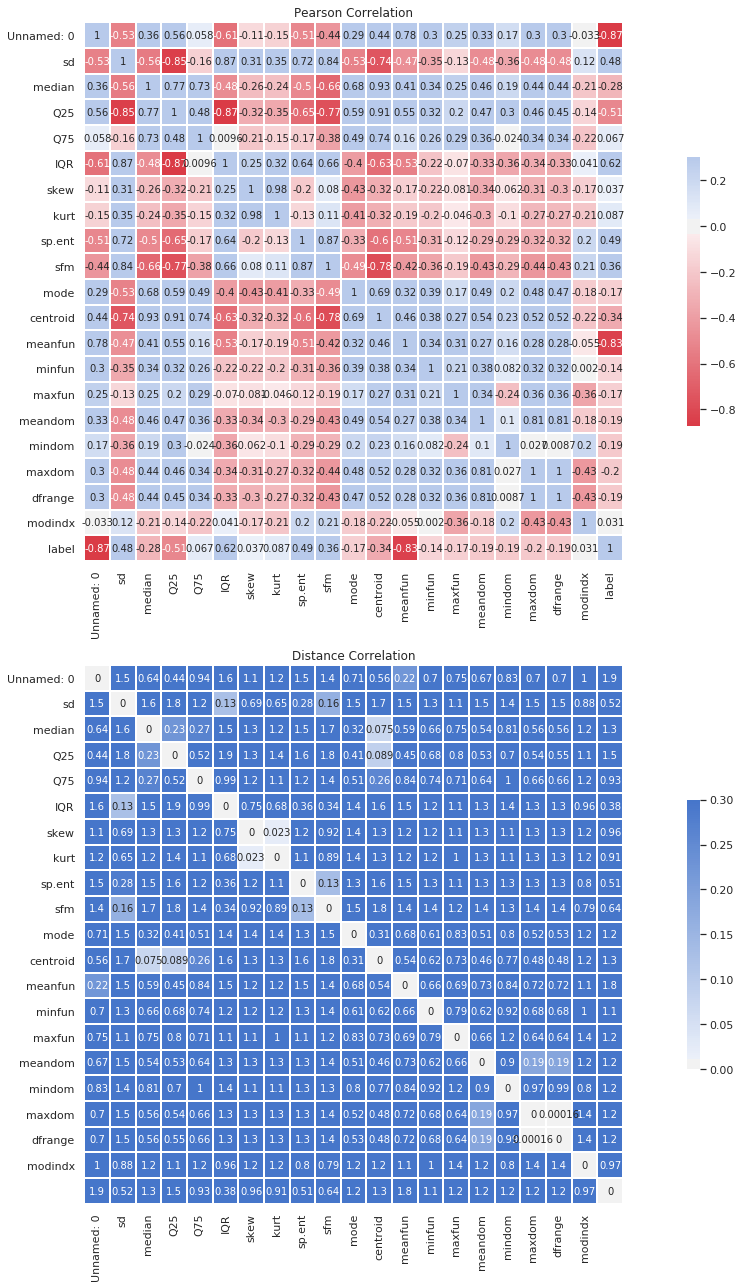

In [61]:
cols = df.columns
fields = cols[:len(cols)-1].to_numpy()

scaler2 = StandardScaler()
df = pd.DataFrame(np.c_[scaler2.fit_transform(df[fields]), df["label"].to_numpy()], columns=cols)

# Pearson 
corr = df.corr()

# Distance Correlation
ds = len(cols)
dcorr = np.zeros((ds, ds))
for i, field in enumerate(cols):
    for k, field2 in enumerate(cols):
        dcorr[i][k] = dcorrelation(df[field], df[field2])


cmap = sns.diverging_palette(10, 255, as_cmap=True)

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.title("Pearson Correlation")
ax = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5})
ax.set_ylim(ds, 0)
plt.subplot(2, 1, 2)
plt.title("Distance Correlation")
ax = sns.heatmap(dcorr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5},
            xticklabels=fields, yticklabels=fields
)
ax.set_ylim(ds, 0)
plt.tight_layout()
plt.show()

**Selecionando os dados que possuem maior relação com audio de acordo com a matriz de correlaçao**

[Text(0.5, 0, 'Unnamed: 0'),
 Text(1.5, 0, 'sd'),
 Text(2.5, 0, 'median'),
 Text(3.5, 0, 'Q25'),
 Text(4.5, 0, 'Q75'),
 Text(5.5, 0, 'IQR'),
 Text(6.5, 0, 'skew'),
 Text(7.5, 0, 'kurt'),
 Text(8.5, 0, 'sp.ent'),
 Text(9.5, 0, 'sfm'),
 Text(10.5, 0, 'mode'),
 Text(11.5, 0, 'centroid'),
 Text(12.5, 0, 'meanfun'),
 Text(13.5, 0, 'minfun'),
 Text(14.5, 0, 'maxfun'),
 Text(15.5, 0, 'meandom'),
 Text(16.5, 0, 'mindom'),
 Text(17.5, 0, 'maxdom'),
 Text(18.5, 0, 'dfrange'),
 Text(19.5, 0, 'modindx'),
 Text(20.5, 0, 'label')]

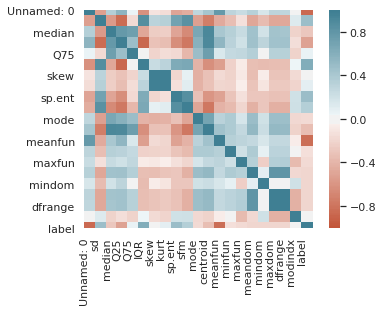

In [62]:
# mapa de correl total
#columns = ['skew', 'kurt', 'sp.ent', 'median', 'dfrange', 'modindx', 'maxdom']
corr = data.corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

[Text(0.5, 0, 'skew'),
 Text(1.5, 0, 'kurt'),
 Text(2.5, 0, 'sp.ent'),
 Text(3.5, 0, 'median'),
 Text(4.5, 0, 'dfrange'),
 Text(5.5, 0, 'modindx'),
 Text(6.5, 0, 'maxdom')]

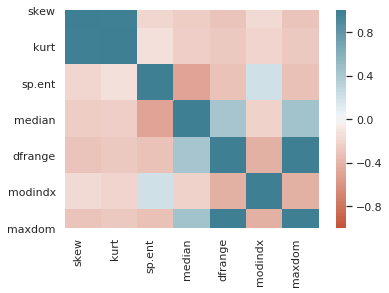

In [63]:
columns = ['skew', 'kurt', 'sp.ent',
           'median', 'dfrange', 'modindx', 'maxdom']
corr = data[columns].corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

[Text(0.5, 0, 'skew'),
 Text(1.5, 0, 'kurt'),
 Text(2.5, 0, 'centroid'),
 Text(3.5, 0, 'mode'),
 Text(4.5, 0, 'sfm'),
 Text(5.5, 0, 'meanfun'),
 Text(6.5, 0, 'Q75'),
 Text(7.5, 0, 'Q25')]

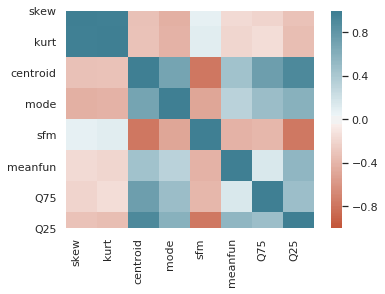

In [64]:
columns = ['skew', 'kurt', 'centroid',
           'mode', 'sfm', 'meanfun', 'Q75', 'Q25']
corr = data[columns].corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

[Text(0.5, 0, 'skew'),
 Text(1.5, 0, 'kurt'),
 Text(2.5, 0, 'sp.ent'),
 Text(3.5, 0, 'mode'),
 Text(4.5, 0, 'sfm'),
 Text(5.5, 0, 'centroid'),
 Text(6.5, 0, 'label')]

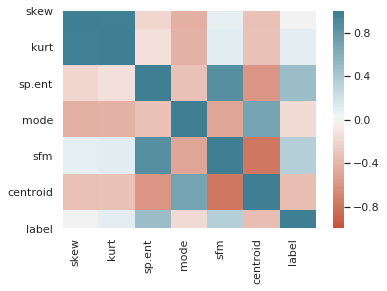

In [65]:
columns = ['skew', 'kurt', 'sp.ent',
           'mode', 'sfm', 'centroid', 'label']
corr = data[columns].corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

In [66]:
columns = df[['skew', 'kurt', 'sp.ent',
           'mode', 'sfm', 'centroid', 'label']]

**Histograma com os melhores parametros relacionados de acordo com a matriz de correlação**

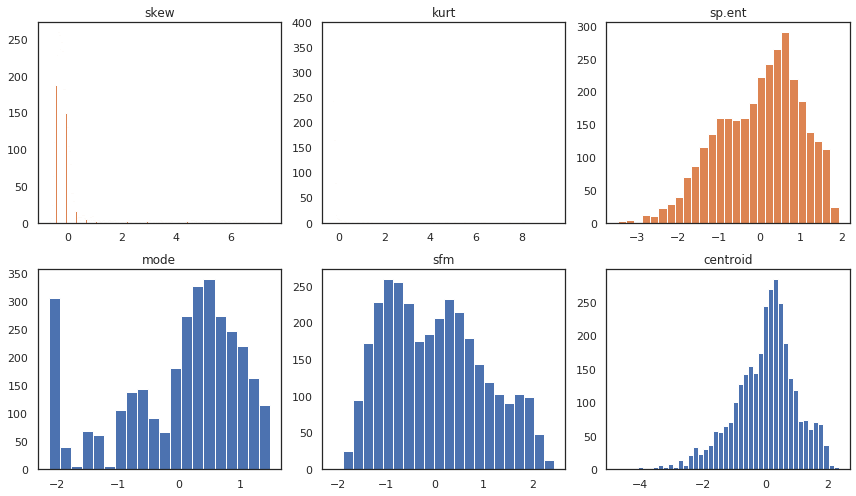

In [67]:
plt.figure(figsize=(12,7))

plt.subplot(2, 3, 1)
plt.title("skew")
plt.hist(columns["skew"], bins='auto', color='C1')

plt.subplot(2, 3, 2)
plt.title("kurt")
plt.hist(columns["kurt"], bins='auto', color='C1')

plt.subplot(2, 3, 3)
plt.title("sp.ent")
plt.hist(columns["sp.ent"], bins='auto', color='C1')

plt.subplot(2, 3, 4)
plt.title("mode")
plt.hist(columns["mode"], bins='auto')

plt.subplot(2, 3, 5)
plt.title("sfm")
plt.hist(columns["sfm"], bins='auto')

plt.subplot(2, 3, 6)
plt.title("centroid")
plt.hist(columns["centroid"], bins='auto')

plt.tight_layout()
plt.show()

In [68]:
fields = ['sd', 'median', 'skew', 'kurt', 'sp.ent', 
          'sfm', 'mode', 'centroid', 'meanfun', 'meandom', 'label']
x_fields = fields[:10]
sound_c = df[fields]

In [47]:
"""#media, min, max, var, std, dos atributos selecionados

#df.head(10)
data = []

for field in ['skew', 'kurt', 'sp.ent', 'mode', 'sfm', 'centroid', 'label']:
    df_sel.append([
        field,
        np.round(np.min(columns[field]), 5),
        np.round(np.max(columns[field]), 5),
        np.round(np.mean(columns[field]), 5),
        np.round(np.median(columns[field]), 5),
        np.round(np.var(columns[field]), 5),
        np.round(np.std(columns[field]), 5)
    ])
    
df_sef2 = pd.DataFrame(df_sel, columns=["Amostras",
                                        "Min",
                                        "Max",
                                        "Media",
                                        "Mediana",
                                        "Variacao",
                                        "Std"
                                       ])

print(df_sef2)
"""

'#media, min, max, var, std, dos atributos selecionados\n\n#df.head(10)\ndata = []\n\nfor field in [\'skew\', \'kurt\', \'sp.ent\', \'mode\', \'sfm\', \'centroid\', \'label\']:\n    df_sel.append([\n        field,\n        np.round(np.min(columns[field]), 5),\n        np.round(np.max(columns[field]), 5),\n        np.round(np.mean(columns[field]), 5),\n        np.round(np.median(columns[field]), 5),\n        np.round(np.var(columns[field]), 5),\n        np.round(np.std(columns[field]), 5)\n    ])\n    \ndf_sef2 = pd.DataFrame(df_sel, columns=["Amostras",\n                                        "Min",\n                                        "Max",\n                                        "Media",\n                                        "Mediana",\n                                        "Variacao",\n                                        "Std"\n                                       ])\n\nprint(df_sef2)\n'

In [69]:
scaler = StandardScaler()
scaler.fit_transform(sound_c[x_fields])
nsound_c = scaler.transform(sound_c[x_fields])
sound_c = pd.DataFrame(np.c_[nsound_c, sound_c["label"].to_numpy()], columns=fields)

In [70]:
data = []
for field in x_fields:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 5),
        np.round(np.max(sound_c[field]), 5),
        np.round(np.mean(sound_c[field]), 5),
        np.round(np.median(sound_c[field]), 5),
        np.round(np.var(sound_c[field]), 5),
        np.round(np.std(sound_c[field]), 5),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd      Min      Max  Mean   Median  Var.  Std  Unique
0        sd  3168 -2.32814  3.49241  -0.0  0.12187   1.0  1.0    3166
1    median  3168 -4.80399  2.07963  -0.0  0.12135   1.0  1.0    3077
2      skew  3168 -0.70720  7.44961   0.0 -0.22243   1.0  1.0    3166
3      kurt  3168 -0.25573  9.43643   0.0 -0.20940   1.0  1.0    3166
4    sp.ent  3168 -3.47939  1.93162   0.0  0.14764   1.0  1.0    3166
5       sfm  3168 -2.09214  2.44922  -0.0 -0.06694   1.0  1.0    3166
6      mode  3168 -2.14121  1.48616  -0.0  0.27616   1.0  1.0    2825
7  centroid  3168 -4.73181  2.34737   0.0  0.13144   1.0  1.0    3166
8   meanfun  3168 -2.70103  2.93596   0.0 -0.07084   1.0  1.0    3166
9   meandom  3168 -1.56420  4.05329   0.0 -0.12076   1.0  1.0    2999


In [71]:
data = []
for field in x_fields:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 5),
        np.round(np.max(sound_c[field]), 5),
        np.round(np.mean(sound_c[field]), 5),
        np.round(np.median(sound_c[field]), 5),
        np.round(np.var(sound_c[field]), 5),
        np.round(np.std(sound_c[field]), 5),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd      Min      Max  Mean   Median  Var.  Std  Unique
0        sd  3168 -2.32814  3.49241  -0.0  0.12187   1.0  1.0    3166
1    median  3168 -4.80399  2.07963  -0.0  0.12135   1.0  1.0    3077
2      skew  3168 -0.70720  7.44961   0.0 -0.22243   1.0  1.0    3166
3      kurt  3168 -0.25573  9.43643   0.0 -0.20940   1.0  1.0    3166
4    sp.ent  3168 -3.47939  1.93162   0.0  0.14764   1.0  1.0    3166
5       sfm  3168 -2.09214  2.44922  -0.0 -0.06694   1.0  1.0    3166
6      mode  3168 -2.14121  1.48616  -0.0  0.27616   1.0  1.0    2825
7  centroid  3168 -4.73181  2.34737   0.0  0.13144   1.0  1.0    3166
8   meanfun  3168 -2.70103  2.93596   0.0 -0.07084   1.0  1.0    3166
9   meandom  3168 -1.56420  4.05329   0.0 -0.12076   1.0  1.0    2999


In [72]:
data = []
for field in x_fields:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 5),
        np.round(np.max(sound_c[field]), 5),
        np.round(np.mean(sound_c[field]), 5),
        np.round(np.median(sound_c[field]), 5),
        np.round(np.var(sound_c[field]), 5),
        np.round(np.std(sound_c[field]), 5),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd      Min      Max  Mean   Median  Var.  Std  Unique
0        sd  3168 -2.32814  3.49241  -0.0  0.12187   1.0  1.0    3166
1    median  3168 -4.80399  2.07963  -0.0  0.12135   1.0  1.0    3077
2      skew  3168 -0.70720  7.44961   0.0 -0.22243   1.0  1.0    3166
3      kurt  3168 -0.25573  9.43643   0.0 -0.20940   1.0  1.0    3166
4    sp.ent  3168 -3.47939  1.93162   0.0  0.14764   1.0  1.0    3166
5       sfm  3168 -2.09214  2.44922  -0.0 -0.06694   1.0  1.0    3166
6      mode  3168 -2.14121  1.48616  -0.0  0.27616   1.0  1.0    2825
7  centroid  3168 -4.73181  2.34737   0.0  0.13144   1.0  1.0    3166
8   meanfun  3168 -2.70103  2.93596   0.0 -0.07084   1.0  1.0    3166
9   meandom  3168 -1.56420  4.05329   0.0 -0.12076   1.0  1.0    2999


In [73]:
data = []
for field in x_fields:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 5),
        np.round(np.max(sound_c[field]), 5),
        np.round(np.mean(sound_c[field]), 5),
        np.round(np.median(sound_c[field]), 5),
        np.round(np.var(sound_c[field]), 5),
        np.round(np.std(sound_c[field]), 5),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd      Min      Max  Mean   Median  Var.  Std  Unique
0        sd  3168 -2.32814  3.49241  -0.0  0.12187   1.0  1.0    3166
1    median  3168 -4.80399  2.07963  -0.0  0.12135   1.0  1.0    3077
2      skew  3168 -0.70720  7.44961   0.0 -0.22243   1.0  1.0    3166
3      kurt  3168 -0.25573  9.43643   0.0 -0.20940   1.0  1.0    3166
4    sp.ent  3168 -3.47939  1.93162   0.0  0.14764   1.0  1.0    3166
5       sfm  3168 -2.09214  2.44922  -0.0 -0.06694   1.0  1.0    3166
6      mode  3168 -2.14121  1.48616  -0.0  0.27616   1.0  1.0    2825
7  centroid  3168 -4.73181  2.34737   0.0  0.13144   1.0  1.0    3166
8   meanfun  3168 -2.70103  2.93596   0.0 -0.07084   1.0  1.0    3166
9   meandom  3168 -1.56420  4.05329   0.0 -0.12076   1.0  1.0    2999


In [ ]:
### ate aqui foi

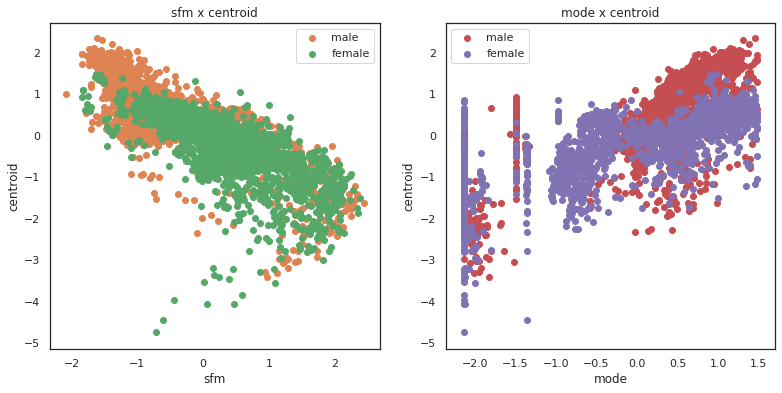

In [85]:
labels, colors, colors2 = ("male", "female"), ("C1", "C2"), ("C3", "C4")
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
for i, color, label in zip([0, 1], colors, labels):
    sfm = sound_c[sound_c["label"] == i]["sfm"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("sfm x centroid")
plt.xlabel("sfm")
plt.ylabel("centroid")
plt.legend()
plt.subplot(1, 2, 2)
for i, color, label in zip([0, 1], colors2, labels):
    sfm = sound_c[sound_c["label"] == i]["mode"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("mode x centroid")
plt.xlabel("mode")
plt.ylabel("centroid")
plt.legend()
plt.show()

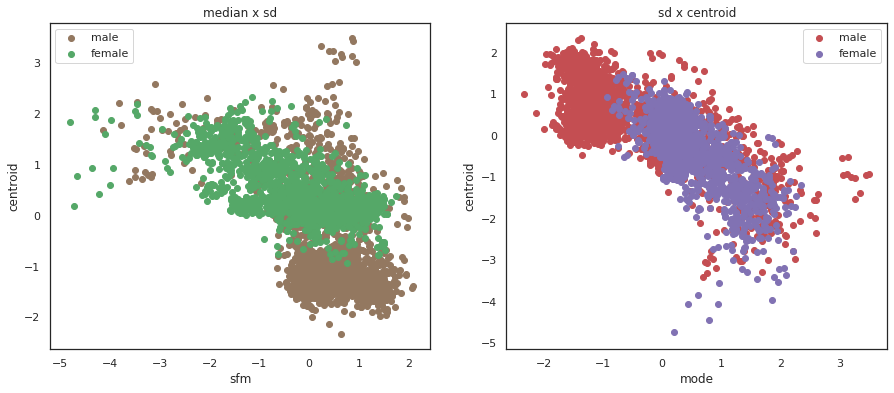

In [127]:
labels, colors, colors2 = ("male", "female"), ("C5", "C2"), ("C3", "C4")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
for i, color, label in zip([0, 1], colors, labels):
    sfm = sound_c[sound_c["label"] == i]["median"]
    centroid = sound_c[sound_c["label"] == i]["sd"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("median x sd")
plt.xlabel("sfm")
plt.ylabel("centroid")
plt.legend()
plt.subplot(1, 2, 2)
for i, color, label in zip([0, 1], colors2, labels):
    sfm = sound_c[sound_c["label"] == i]["sd"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("sd x centroid")
plt.xlabel("mode")
plt.ylabel("centroid")
plt.legend()
plt.show()

In [87]:
fields = cols[:len(cols)-1].to_numpy()
x = np.copy(df[fields].to_numpy())
y = np.copy(df["label"].to_numpy())
# train test split 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [88]:
# Logistic function
clf = LogisticRegressionImpl()
J, ACC = clf.train(x_train, y_train, lr=1e-1)

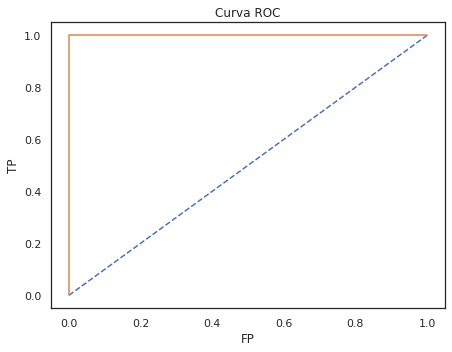

In [89]:
probs = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Curva ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel("FP")
plt.ylabel("TP")
plt.tight_layout()
plt.show()

In [ ]:
### ate aqui foi

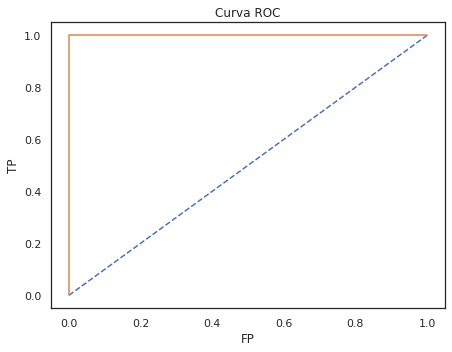

In [90]:
probs = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Curva ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel("FP")
plt.ylabel("TP")
plt.tight_layout()
plt.show()

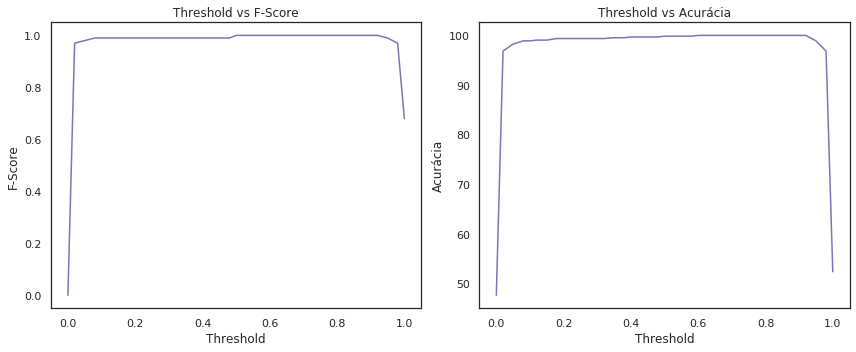

                 15 últimos resultados: 
    Threshold  Acurácia  Erros  Recall  Precisão  F-Score
24       0.60    100.00   0.00     1.0      1.00     1.00
25       0.62    100.00   0.00     1.0      1.00     1.00
26       0.65    100.00   0.00     1.0      1.00     1.00
27       0.68    100.00   0.00     1.0      1.00     1.00
28       0.70    100.00   0.00     1.0      1.00     1.00
29       0.73    100.00   0.00     1.0      1.00     1.00
30       0.75    100.00   0.00     1.0      1.00     1.00
31       0.78    100.00   0.00     1.0      1.00     1.00
32       0.80    100.00   0.00     1.0      1.00     1.00
33       0.82    100.00   0.00     1.0      1.00     1.00
34       0.85    100.00   0.00     1.0      1.00     1.00
35       0.88    100.00   0.00     1.0      1.00     1.00
36       0.90    100.00   0.00     1.0      1.00     1.00
37       0.92    100.00   0.00     1.0      1.00     1.00
20       0.50     99.84   0.16     1.0      1.00     1.00
21       0.52     99.84   0.16 

In [113]:
def calculate_resultados(y_test, y_pred):
    with np.errstate(all='ignore'):
        cfm = confusion_matrix(y_test, y_pred)
        acertos = cfm[0, 0] + cfm[1, 1]
        erros = cfm[0, 1] + cfm[1, 0]
        precisao = np.round(cfm[0, 0] / (cfm[0, 0] + cfm[0, 1]), 2)
        recall = np.round(cfm[0, 0] / (cfm[0, 0] + cfm[1, 0]), 2)
        fscore = np.round((2 * recall * precisao) / (recall + precisao), 2)
        acuracia = np.round(acertos / len(y_test) * 100, 2)
        erros = np.round(erros / len(y_test) * 100, 2)
    return acuracia, erros, recall, precisao, fscore

df = pd.DataFrame(resultados, columns=["Threshold", "Acurácia", "Erros", "Recall", "Precisão", "F-Score"])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Threshold vs F-Score")
plt.plot(df["Threshold"], df["F-Score"], c="C4")
plt.xlabel("Threshold")
plt.ylabel("F-Score")
plt.subplot(1, 2, 2)
plt.title("Threshold vs Acurácia")
plt.plot(df["Threshold"], df["Acurácia"], c="C4")
plt.xlabel("Threshold")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

ordered = df.sort_values(by=["F-Score", "Acurácia"], ascending=False)

def print_resultados(acuracia, erros, recall, precisao, fscore):
    print("Acuráciaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa:")
    print("=============")
    print(f"Acertos: {acuracia}%")
    print(f"Erros : {erros}%")
    print("=============")
    
    print("=============")
    print(f"Recall {recall} - Precisão {precisao} F-Score - {fscore}")

resultados = []

for thre in np.linspace(0, 1, 41):
    thre = np.round(thre, 2)
    y_pred = clf.predict(x_test, threshold=thre)
    resultados.append(np.concatenate((np.array([thre]), calculate_resultados(y_test, y_pred))))
resultados = np.nan_to_num(np.array(resultados))

print("                 15 últimos resultados: ")
print(" ==================================================== ")
print(ordered.head(-15))

In [114]:
best_threshold = ordered["Threshold"].to_numpy()[0]
print(f"Melhor threshold encontrado: {best_threshold}")
print()

y_pred = clf.predict(x_test, threshold=best_threshold)

print("Acurácia:")
print("============= ")
print(f"Acertos: {np.round(accuracy_score(y_test, y_pred) * 100, 2)}%")
print(f"Erros: {np.round((1-accuracy_score(y_test, y_pred)) * 100, 2)}%")

print()
print("Classificação:")
print("============= ")

report = classification_report(y_test.astype(np.int), y_pred.astype(np.int), output_dict=True)
items = []

for key, value in report.items():
    if isinstance(value, dict) and key.isdigit():
        items.append([
            key,
            np.round(value["precision"], 2),
            np.round(value["recall"], 2),
            np.round(value["f1-score"], 2),
            np.round(value["support"], 2)
        ])
        
dfclass = pd.DataFrame(items, columns=["Classe", "Precisão", "Recall", "F1-Score", "Support"])
print(dfclass)

Melhor threshold encontrado: 0.6

Acurácia:
Acertos: 100.0%
Erros: 0.0%

Classificação:
  Classe  Precisão  Recall  F1-Score  Support
0      0       1.0     1.0       1.0      332
1      1       1.0     1.0       1.0      302


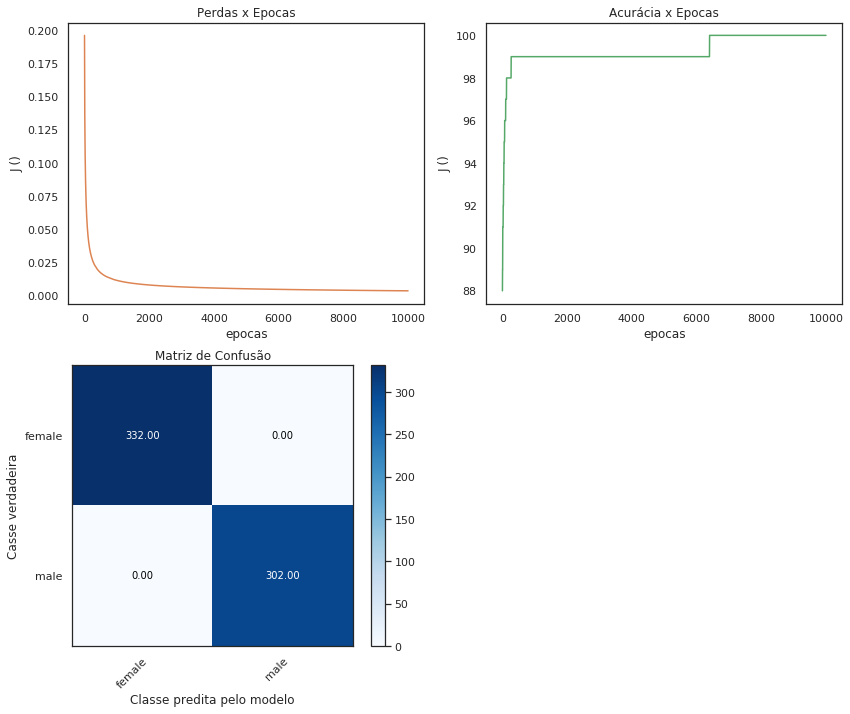

In [117]:
cfm = confusion_matrix(y_test.astype(np.int), y_pred.astype(np.int))

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title("Perdas x Epocas")
plt.xlabel("epocas")
plt.ylabel("J ()")
plt.plot(J, color="C1")
plt.subplot(2, 2, 2)
plt.title("Acurácia x Epocas")
plt.xlabel("epocas")
plt.ylabel("J ()")
plt.plot(ACC, color="C2")
ax = plt.subplot(2, 2, 3)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       
       # labels
       xticklabels=["female", "male"], yticklabels=["female", "male"],
       title="Matriz de Confusão",
       ylabel='Casse verdadeira',
       xlabel='Classe predita pelo modelo')

# Rotacao do label
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)
plt.tight_layout()
plt.show()

## EX 2

In [118]:
def read_dataset(filename, ground_truth=False):
    columns = []
    with open(filename, "r") as fh:
        for line in fh.readlines():
            columns.append([float(col) for col in line.strip().split()])
    if ground_truth:
        columns = np.array(columns).flatten().astype(np.int)
    return pd.DataFrame(columns)

har_x_train = read_dataset("X_train.txt")
har_x_test = read_dataset("X_test.txt")
har_y_train = read_dataset("y_train.txt", ground_truth=True)
har_y_test = read_dataset("y_test.txt", ground_truth=True)

In [119]:
print(f"Dados de treinamento : {har_x_train.shape[0]}")
print(f"Dados de teste: {har_x_test.shape[0]}")
print(f"Atributos: {har_x_train.shape[1]}")

print()
print("10 primeiros registros:")
print("============= ")
print(har_x_train.head(10))

Dados de treinamento : 7352
Dados de teste: 2947
Atributos: 561

10 primeiros registros:
        0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
5  0.277199 -0.010098 -0.105137 -0.997335 -0.990487 -0.995420 -0.997627   
6  0.279454 -0.019641 -0.110022 -0.996921 -0.967186 -0.983118 -0.997003   
7  0.277432 -0.030488 -0.125360 -0.996559 -0.966728 -0.981585 -0.996485   
8  0.277293 -0.021751 -0.120751 -0.997328 -0.961245 -0.983672 -0.997596   
9  0.280586 -0.009960 -0.106065 -0.994803 -0.972758 -0.986244 -0.995405   

        7         8         9    ...       551       552       553       554  \
0 -0.

In [121]:
x_har_train = har_x_train.to_numpy()
x_har_test = har_x_test.to_numpy()
y_har_train = har_y_train.to_numpy().flatten()
y_har_test = har_y_test.to_numpy().flatten()

In [122]:
# Logistic function
clfsft = LogisticRegressionImpl()
J, ACC = clfsft.train(x_har_train, y_har_train, lr=1e-1)

In [125]:
y_har_pred = clfsft.predict(x_har_test)
y_har_test_on = np.argmax(one_hot_encode(y_har_test), axis=1)

print("Testando o modelo no conjunto de testes")
print("============= ")

print("Acurácia:")
print(f"Acertos: {np.round(accuracy_score(y_har_test_on, y_har_pred) * 100, 2)}%")
print(f"Erros  : {np.round((1-accuracy_score(y_har_test_on, y_har_pred)) * 100, 2)}%")

print()
print("Resultados :")

print("============= ")
report = classification_report(y_har_test_on + 1, y_har_pred + 1, output_dict=True)
items = []
for key, value in report.items():
    if isinstance(value, dict) and key.isdigit():
        items.append([
            key,
            np.round(value["precision"], 2),
            np.round(value["recall"], 2),
            np.round(value["f1-score"], 2),
            np.round(value["support"], 2)
        ])
dfclass = pd.DataFrame(items, columns=["Classe", "Precisão", "Recall", "F1-Score", "Support"])
print(dfclass)

Testando o modelo no conjunto de testes
Acurácia:
Acertos: 94.84%
Erros  : 5.16%

Resultados :
  Classe  Precisão  Recall  F1-Score  Support
0      1      0.94    0.99      0.96      496
1      2      0.94    0.95      0.95      471
2      3      0.97    0.91      0.94      420
3      4      0.94    0.89      0.91      491
4      5      0.91    0.94      0.93      532
5      6      1.00    1.00      1.00      537


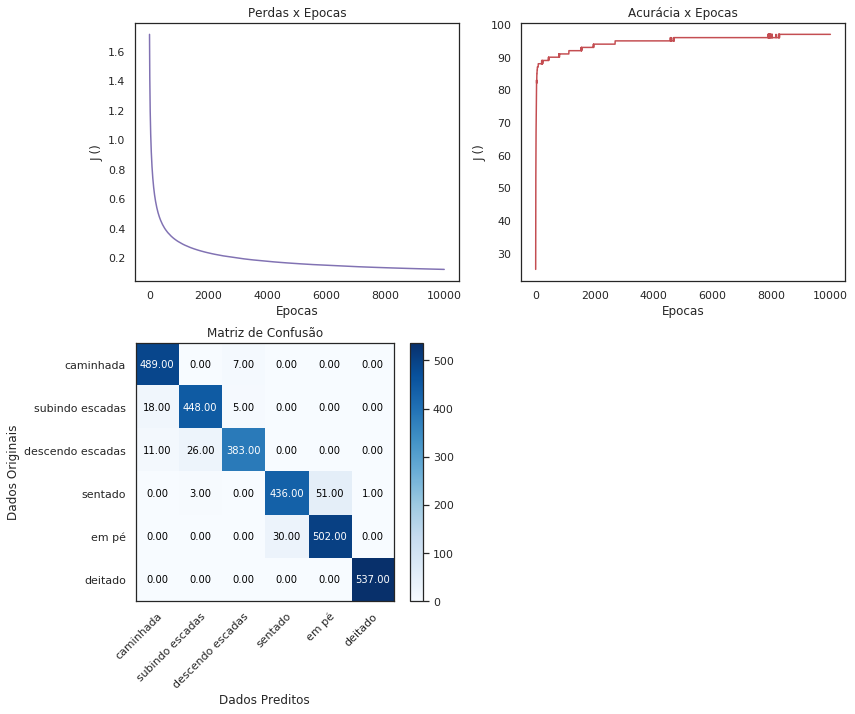

In [124]:
labels = ["caminhada", "subindo escadas", "descendo escadas", "sentado", "em pé", "deitado"]
cfm = confusion_matrix(y_har_test_on, y_har_pred)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.title("Perdas x Epocas")
plt.xlabel("Epocas")
plt.ylabel("J ()")
plt.plot(J, color="C4")
plt.subplot(2, 2, 2)
plt.title("Acurácia x Epocas")
plt.xlabel("Epocas")
plt.ylabel("J ()")
plt.plot(ACC, color="C3")

ax = plt.subplot(2, 2, 3)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Dados Originais',
       xlabel='Dados Preditos')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(5.5, -0.5)
plt.tight_layout()
plt.show()

**Resposta (a)**

In [56]:
import math 
#calculos de entropia para verificaçã da materia ia660

(3/4)*(math.log(0.75,2))
math.log(3,2)
1/3
-(0.33*(math.log(0.33,2)))+(0.33*(math.log(0.33,2)))+(0.33*(math.log(0.33,2)))
math.log(3,2)
hx = -np.log2(0.333)

hx

1.5864059175908247